# Weed Detection using YOLO11
By
- Samuel Waweru Kamau (ENM221-0040/2020)
- Ray Ngigi Njoroge (ENM221-0283/2020)
## Introduction
YOLO11 (You Only Look Once, version 11) is a state-of-the-art object detection model known for its speed and accuracy. It processes images in real-time by dividing them into grids and predicting bounding boxes and class probabilities simultaneously. This efficiency makes it well-suited for agricultural applications such as weed detection, where timely and precise identification of unwanted vegetation can enhance crop yields and reduce reliance on chemical herbicides.


In [2]:
from IPython.core.display import display, HTML

html_code = '''
<div style="display: flex; justify-content: center; gap: 20px; align-items: center;">
    <figure>
        <img src="/kaggle/input/miscelleneous/clover_weed.jpg" width="500" height="400">
        <figcaption style="text-align: center;">Weed : Clover</figcaption>
    </figure>
    <figure>
        <img src="/kaggle/input/miscelleneous/spinach.jpg" width="500" height="400">
        <figcaption style="text-align: center;">Crop : Spinach</figcaption>
    </figure>
</div>
'''

display(HTML(html_code))


/tmp/ipykernel_10/99490464.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


 To achieve weed detection, we fine-tune a pre-trained YOLO11 model using a dataset consisting of labeled images of crops and weeds. By training the model with annotated agricultural data, it learns to distinguish between crops and unwanted plants, enabling automated weed control in smart farming systems.


---
# Data Preparation

### Data Collection



### Data Splitting

In [3]:
! pip install split-folders


[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [5]:
import os
import shutil
from collections import Counter

# Define paths
original_dataset_path = "/kaggle/input/agri-data/data"  # Read-only directory
dataset_path = "/kaggle/working/agri_data"  # Writable directory

# Copy dataset to /kaggle/working/
if not os.path.exists(dataset_path):
    shutil.copytree(original_dataset_path, dataset_path)

# Define class folders
crop_folder = os.path.join(dataset_path, "crop")
weed_folder = os.path.join(dataset_path, "weed")

# Create subfolders if they don’t exist
os.makedirs(crop_folder, exist_ok=True)
os.makedirs(weed_folder, exist_ok=True)

# Process all images and annotation files
for file in os.listdir(dataset_path):
    if file.endswith(".jpeg"):
        annotation_file = file.replace(".jpeg", ".txt")  # Find the corresponding annotation file
        annotation_path = os.path.join(dataset_path, annotation_file)
        image_path = os.path.join(dataset_path, file)

        # Ensure both image and annotation files exist
        if os.path.exists(annotation_path):
            with open(annotation_path, "r") as f:
                lines = f.readlines()

            # Skip empty annotation files
            if not lines:
                print(f"⚠️ Skipping {file} (empty annotation)")
                continue

            # Count occurrences of each class
            class_labels = [line.split()[0] for line in lines]
            most_common_class = Counter(class_labels).most_common(1)[0][0]  # Get most frequent class

            # Determine destination folder
            if most_common_class == "0":  # Crop
                dest_folder = crop_folder
            elif most_common_class == "1":  # Weed
                dest_folder = weed_folder
            else:
                print(f"⚠️ Skipping {file} (unknown class label: {most_common_class})")
                continue

            # Move both image and annotation files to the determined folder
            shutil.move(image_path, os.path.join(dest_folder, file))
            shutil.move(annotation_path, os.path.join(dest_folder, annotation_file))

print("✅ Dataset successfully organized into class folders with paired image and annotation files!")


✅ Dataset successfully organized into class folders with paired image and annotation files!


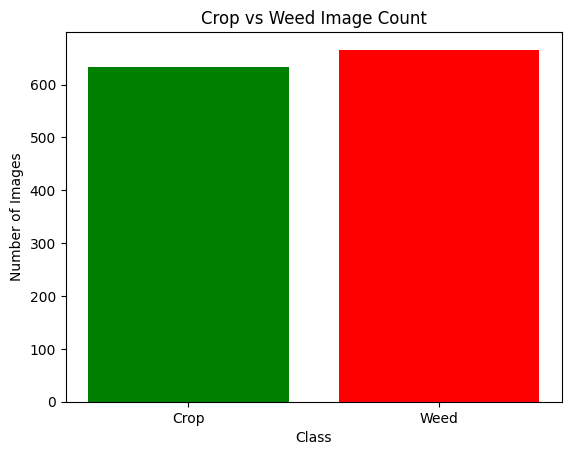

In [6]:
import matplotlib.pyplot as plt

# Define paths
crop_folder = "/kaggle/working/agri_data/crop"
weed_folder = "/kaggle/working/agri_data/weed"

# Count number of files in each folder
num_crop_images = len([f for f in os.listdir(crop_folder) if f.endswith(".jpeg")])
num_weed_images = len([f for f in os.listdir(weed_folder) if f.endswith(".jpeg")])

# Create a bar chart
categories = ['Crop', 'Weed']
counts = [num_crop_images, num_weed_images]

plt.bar(categories, counts, color=['green', 'red'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Crop vs Weed Image Count')
plt.show()

In [7]:
import os
import shutil
import random

# Define paths
dataset_path = "/kaggle/working/agri_data"  # Your original dataset path
split_path = "/kaggle/working/agri_data_split"  # The path where your split data will go

# Create directories if they don’t exist
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(split_path, split), exist_ok=True)

# Get all image files for both crop and weed classes
all_image_files = []
for folder in ['crop', 'weed']:
    folder_path = os.path.join(dataset_path, folder)
    image_files = [os.path.join(folder, f) for f in os.listdir(folder_path) if f.endswith(".jpeg")]
    all_image_files.extend(image_files)

# Shuffle the image files randomly
random.shuffle(all_image_files)

# Calculate split indices
total_files = len(all_image_files)
train_end = int(0.8 * total_files)
val_end = train_end + int(0.1 * total_files)

# Split the data into train, val, and test
train_files = all_image_files[:train_end]
val_files = all_image_files[train_end:val_end]
test_files = all_image_files[val_end:]

# Function to move both image and annotation files
def move_files(files, split_folder):
    for file in files:
        # Move the image file
        image_src = os.path.join(dataset_path, file)
        image_dst = os.path.join(split_path, split_folder, os.path.basename(file))
        shutil.move(image_src, image_dst)

        # Move the corresponding annotation file
        annotation_file = file.replace(".jpeg", ".txt")
        annotation_src = os.path.join(dataset_path, annotation_file)
        if os.path.exists(annotation_src):  # Ensure the annotation file exists
            annotation_dst = os.path.join(split_path, split_folder, os.path.basename(annotation_file))
            shutil.move(annotation_src, annotation_dst)

# Move the files to the appropriate directories
move_files(train_files, 'train')
move_files(val_files, 'val')
move_files(test_files, 'test')

print("✅ Dataset successfully split into train, val, and test folders with annotations!")


✅ Dataset successfully split into train, val, and test folders with annotations!


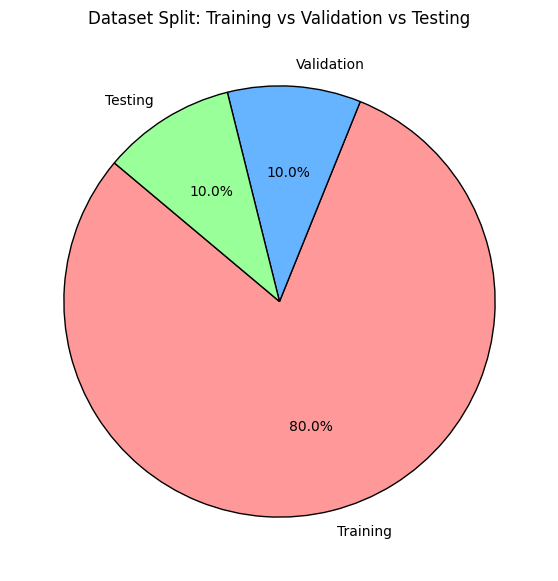

In [8]:
# Define dataset sizes
train_size = len(train_files)
val_size = len(val_files)
test_size = len(test_files)

# Labels and sizes
labels = ['Training', 'Validation', 'Testing']
sizes = [train_size, val_size, test_size]
colors = ['#ff9999','#66b3ff','#99ff99']  # Colors for each section

# Create pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, wedgeprops={'edgecolor': 'black'})

# Title and display
plt.title("Dataset Split: Training vs Validation vs Testing")
plt.show()

---
# Training the Model

In [9]:
! pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.8/914.8 kB 15.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [10]:
from ultralytics import YOLO
import torch
import cv2

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [11]:
# Load a model
model = YOLO("yolo11n.yaml")


#path: C:\Users\hp\OneDrive\Documents\5th_Year\Weed_Detector\agri_data
#train: data
#val: data
#test:test

# classes
#names:
#  0: crop
#  1: weed


In [12]:
# Training the model
train_results = model.train(
    data="/kaggle/input/updated/config.yaml",  # path to dataset YAML
    epochs=20  # number of training epochs
    )



Ultralytics 8.3.72 🚀 Python-3.10.16 torch-2.5.0+cu124 CPU (Intel Xeon 2.00GHz)
engine/trainer: task=detect, mode=train, model=yolo11n.yaml, data=/kaggle/input/updated/config.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

100%|██████████| 755k/755k [00:00<00:00, 38.7MB/s]
E0000 00:00:1738855259.778521      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/agri_data_split/train... 1040 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1040/1040 [00:00<00:00, 1364.71it/s]


train: New cache created: /kaggle/working/agri_data_split/train.cache


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.3' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/agri_data_split/val... 130 images, 0 backgrounds, 0 corrupt: 100%|██████████| 130/130 [00:00<00:00, 1315.68it/s]


val: New cache created: /kaggle/working/agri_data_split/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      3.073      3.756      4.149         48        640: 100%|██████████| 65/65 [02:04<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


                   all        130        222    0.00416      0.687     0.0971     0.0303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      2.927      3.415      3.638         43        640: 100%|██████████| 65/65 [01:59<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


                   all        130        222      0.645      0.159     0.0951     0.0223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      2.595      3.151      3.208         37        640: 100%|██████████| 65/65 [01:56<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


                   all        130        222       0.11      0.253     0.0759     0.0203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G      2.427      2.956      2.999         45        640: 100%|██████████| 65/65 [01:57<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


                   all        130        222      0.211      0.472      0.195     0.0669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      2.292      2.727      2.813         54        640: 100%|██████████| 65/65 [01:55<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


                   all        130        222      0.369      0.447      0.324      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      2.175      2.494      2.685         43        640: 100%|██████████| 65/65 [01:54<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


                   all        130        222       0.32       0.34      0.204     0.0766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      2.063      2.365       2.56         55        640: 100%|██████████| 65/65 [01:56<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


                   all        130        222      0.409      0.664       0.48      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      1.988      2.244      2.482         51        640: 100%|██████████| 65/65 [01:57<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


                   all        130        222       0.62      0.474      0.531      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G      1.932      2.139       2.41         45        640: 100%|██████████| 65/65 [01:58<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


                   all        130        222      0.592      0.412      0.503      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G      1.867      2.059      2.344         56        640: 100%|██████████| 65/65 [01:56<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


                   all        130        222        0.6      0.406      0.454      0.216
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G      1.739      1.864      2.386         32        640: 100%|██████████| 65/65 [01:54<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


                   all        130        222      0.539      0.595      0.608      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      1.681      1.664      2.303         27        640: 100%|██████████| 65/65 [01:51<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


                   all        130        222      0.666      0.519      0.593      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G      1.633      1.568      2.259         21        640: 100%|██████████| 65/65 [01:53<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


                   all        130        222        0.7      0.665      0.728      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G      1.546      1.489      2.163         21        640: 100%|██████████| 65/65 [01:54<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


                   all        130        222      0.762      0.427        0.5      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G      1.549      1.477      2.169         21        640: 100%|██████████| 65/65 [01:54<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


                   all        130        222      0.761      0.647       0.77       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G      1.476      1.425      2.108         26        640: 100%|██████████| 65/65 [01:54<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


                   all        130        222      0.769      0.719       0.77       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G      1.468      1.369      2.088         29        640: 100%|██████████| 65/65 [01:56<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


                   all        130        222      0.798      0.674      0.762      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G      1.408      1.324      2.027         29        640: 100%|██████████| 65/65 [01:53<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


                   all        130        222      0.798      0.715      0.804      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G      1.407      1.289      2.027         18        640: 100%|██████████| 65/65 [01:54<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


                   all        130        222      0.834      0.707      0.793      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G      1.381      1.257      2.021         19        640: 100%|██████████| 65/65 [01:53<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


                   all        130        222      0.775      0.751      0.798      0.463

20 epochs completed in 0.689 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.72 🚀 Python-3.10.16 torch-2.5.0+cu124 CPU (Intel Xeon 2.00GHz)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


                   all        130        222      0.836      0.704      0.793      0.475
                  crop         65        145      0.749      0.641      0.753      0.459
                  weed         65         77      0.922      0.766      0.833      0.491
Speed: 0.4ms preprocess, 36.3ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train


---
# Model Evaluation Metrics

### 1. Mean Average Precision (mAP)
- Measures model accuracy across different IoU thresholds.
- Higher values indicate better performance.

### 2. Precision, Recall, and F1-score
- **Precision**: Fraction of correct weed detections over total detections.
- **Recall**: Fraction of detected weeds over total actual weeds.
- **F1-score**: Harmonic mean of Precision and Recall.

### 3. Confusion Matrix
- Helps analyze misclassifications between weeds and crops.
- Should have high true positives and low false positives/negatives.

### 4. Intersection over Union (IoU)
- Measures overlap between predicted and actual bounding boxes.
- Higher IoU means better localization.

### 5. Inference on Test Images
- Qualitative assessment using sample images.
- Helps detect common misclassification issues.

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on test set
metrics = model.val(data="/kaggle/input/updated/config.yaml", split="test")

# Extract key metrics
mAP50 = metrics.box.map50  # mAP@0.5
mAP5095 = metrics.box.map  # mAP@0.5:0.95
precision = metrics.box.mp  # Mean Precision
recall = metrics.box.mr  # Mean Recall
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print results
print(f"🔹 mAP@0.5: {mAP50:.4f}")
print(f"🔹 mAP@0.5:0.95: {mAP5095:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1-score: {f1_score:.4f}")

print(dir(metrics.box))  # List all available attributes



Ultralytics 8.3.72 🚀 Python-3.10.16 torch-2.5.0+cu124 CPU (Intel Xeon 2.00GHz)


val: Scanning /kaggle/working/agri_data_split/test.cache... 130 images, 0 backgrounds, 0 corrupt: 100%|██████████| 130/130 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.11it/s]


                   all        130        236      0.801      0.691       0.77      0.415
                  crop         64        142      0.793      0.754       0.85      0.468
                  weed         66         94      0.808      0.628      0.691      0.361
Speed: 0.4ms preprocess, 26.1ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train7
🔹 mAP@0.5: 0.7701
🔹 mAP@0.5:0.95: 0.4145
🔹 Precision: 0.8006
🔹 Recall: 0.6906
🔹 F1-score: 0.7416
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'all_ap', 'ap', 'ap50', 'ap_class_index', 'class_result', 'curves', 'curves_results', 'f1', 'f1_curve', 'fitness', 'map', 'map50', 'map75', 'maps', 'mean_res

The model evaluation results provide insights into its performance in detecting and classifying crops and weeds. The dataset used for testing contained **130 images** with 236 objects in total. The model achieved an overall precision of **80.1%**, meaning it correctly identified positive detections in **80.1%** of cases. However, its recall was **69.1%**, indicating that it missed **30.9%** of actual objects. The **mean Average Precision (mAP)** at **IoU 0.5 (mAP@0.5)**, which measures the accuracy of predictions with a **50%** overlap threshold, was **77.0%**, while the stricter **mAP@0.5:0.95**, which averages precision across multiple IoU thresholds, was lower at **41.5%**, reflecting the challenge of detecting objects with high localization accuracy.

Breaking it down per class, the model performed slightly better on weeds in terms of precision (80.8%) but had a lower recall (62.8%), meaning it missed a significant number of weed instances. On the other hand, it detected crops more reliably, with a recall of 75.4%, but at a slightly lower precision (79.3%). The F1-score, which balances precision and recall, was 74.16%, suggesting a moderate trade-off between false positives and false negatives.

In terms of speed, the model was efficient, with an average preprocessing time of 0.4ms, inference time of 26.1ms per image, and post-processing time of 0.7ms. These results indicate that while the model performs well, there is room for improvement, especially in recall for weeds, which could be enhanced through additional training data or fine-tuning hyperparameters.

In [19]:
# Save the trained model
model.save("/kaggle/working/model.pt")


---
# Applying Model on House-Hold Crop

In [24]:
print(os.listdir('/kaggle/working/runs/detect/train7'))  # Update path with the correct one if needed


['val_batch2_labels.jpg', 'val_batch1_pred.jpg', 'val_batch0_labels.jpg', 'R_curve.png', 'confusion_matrix_normalized.png', 'PR_curve.png', 'confusion_matrix.png', 'val_batch0_pred.jpg', 'P_curve.png', 'val_batch1_labels.jpg', 'val_batch2_pred.jpg', 'F1_curve.png']



0: 640x640 1 weed, 61.3ms
Speed: 2.7ms preprocess, 61.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


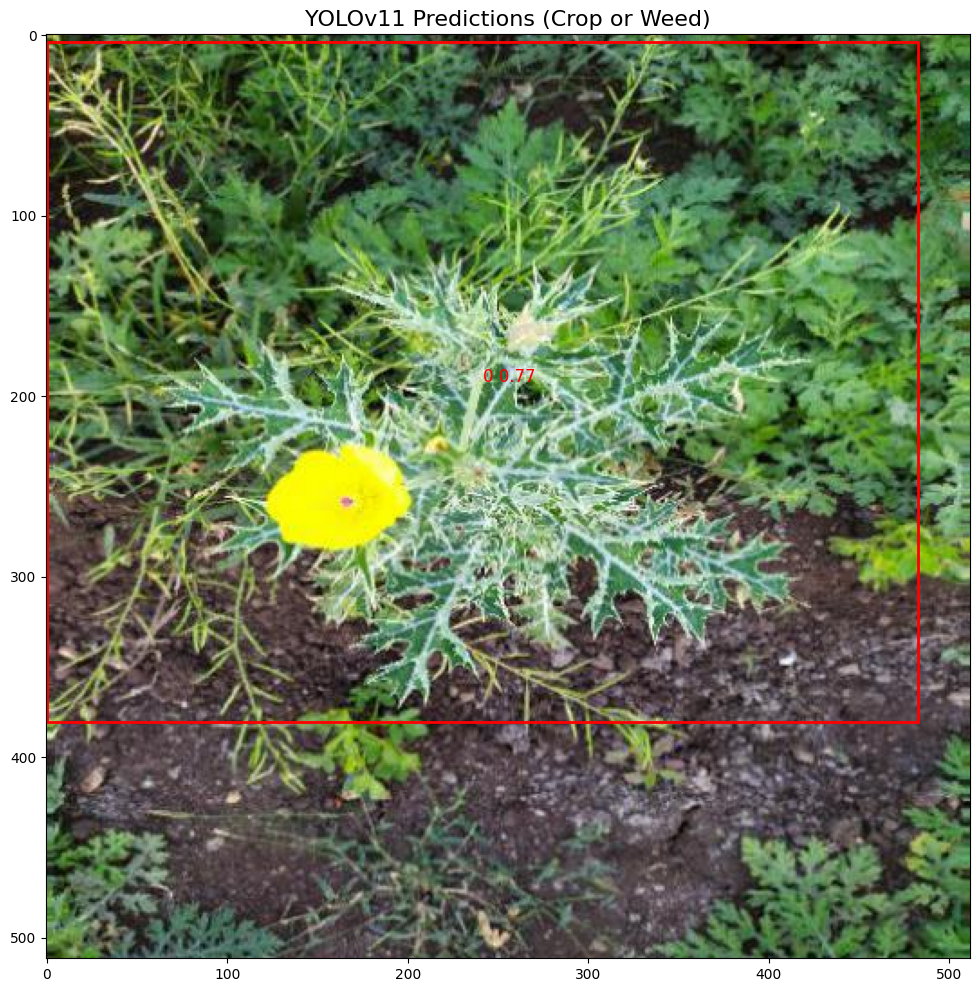

In [27]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the YOLO model
model_path = '/kaggle/working/model.pt'  # Update this path to your model file
model = YOLO(model_path)  # Load YOLO model


# Set confidence threshold
threshold = 0.5

# Function to predict if the image is a weed or crop
def predict_image(image_path):
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

    # Perform inference
    results = model(img, conf=threshold)  # Use the threshold for confidence

    # Since results is a list, access the first result
    result = results[0]

    # Extract the results (boxes, labels, and scores)
    boxes = result.boxes.xywh  # Box coordinates (x, y, width, height)
    labels = result.names  # Class names (weed or crop)
    scores = result.boxes.conf  # Confidence scores
    
    # Visualize results
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(img)
    
    for i, (box, score, label) in enumerate(zip(boxes, scores, labels)):
        if score >= threshold:  # Apply threshold filter
            x, y, w, h = box
            rect = plt.Rectangle((x - w/2, y - h/2), w, h, linewidth=2, edgecolor="red", facecolor="none")
            ax.add_patch(rect)
            ax.text(x, y, f"{label} {score:.2f}", color='red', fontsize=12)
    
    plt.title("YOLOv11 Predictions (Crop or Weed)", fontsize=16)
    plt.show()


# Example usage on a personal image
image_path = '/kaggle/working/agri_data_split/train/agri_0_1017.jpeg'  # Update this with your image path
predict_image(image_path)



0: 640x640 1 crop, 63.1ms
Speed: 3.0ms preprocess, 63.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


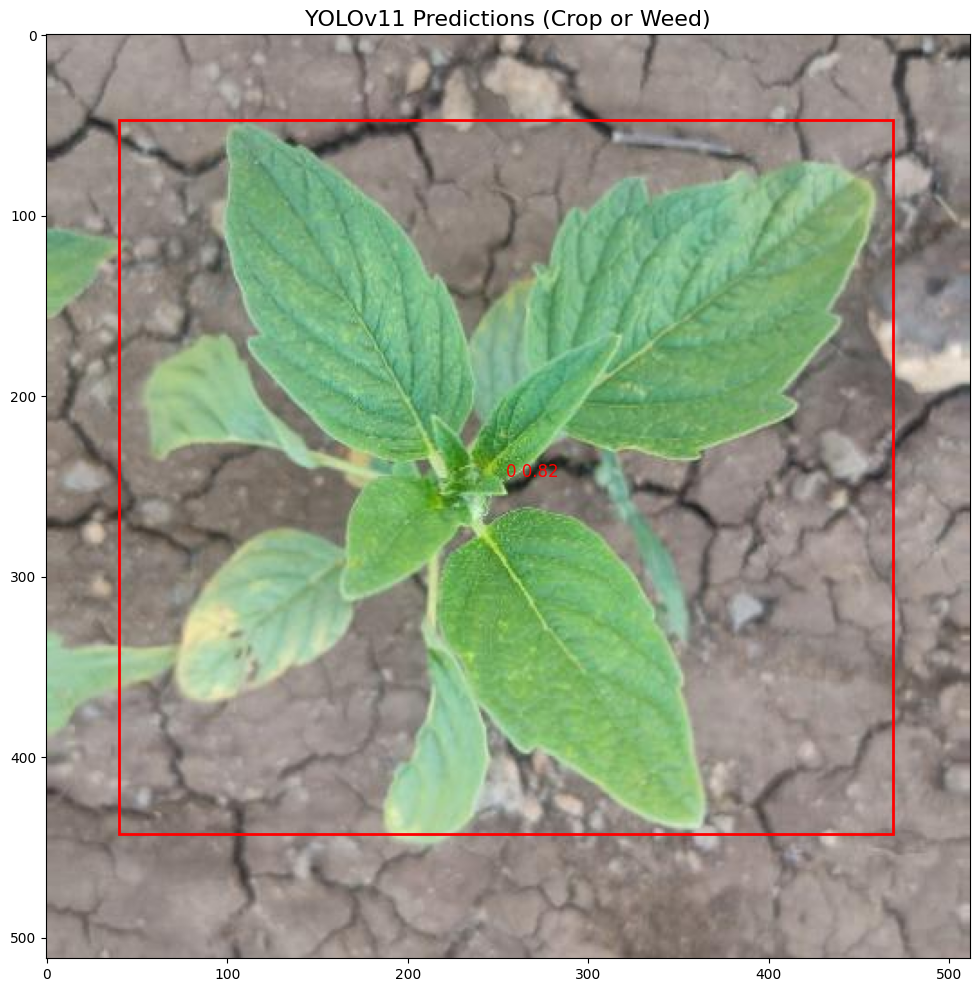

In [34]:
# Example usage on a personal image
image_path = '/kaggle/working/agri_data_split/train/agri_0_1211.jpeg'  # Update this with your image path
predict_image(image_path)# sesame plant

# Recommendations

To improve the detection of weeds from crops in your YOLOv11 model, several strategies can be considered. 
- Firstly, ensuring high-quality and diverse training data is crucial. Including a wide variety of images on Testing Crops like Spinach and common weeds within JKUAT, covering different lighting conditions, angles, and weed/crop variations, will help the model generalize better and be more robust.
- Augmenting the dataset with techniques like rotation, flipping, and scaling can simulate various real-world scenarios, further boosting the model's ability to detect weeds under diverse conditions. We can also consider fine-tuning the model with a higher learning rate or adjusting the batch size to optimize training i.e. Increasing the number of Epoch as we monitor performance.
- Implementing techniques like data normalization and improving the balance between crop and weed images in the dataset can also prevent the model from being biased toward one class. Moreover, experimenting with different IoU (Intersection over Union) thresholds during training and inference can help in improving localization accuracy, particularly for overlapping instances of weeds and crops.
- Leveraging post-processing techniques like non-maximum suppression (NMS) with optimized thresholding may help remove duplicate predictions and improve the clarity of the final detection results.
- Combining these improvements will likely enhance both the precision and recall of your weed detection model.